In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.animation as anim 
from scipy import integrate
from tqdm import tqdm
%matplotlib ipympl

In [2]:
rL = 1.7374e6
mT = 5.9736e24
rT = 6.371e6
mL = 0.07349e24
d = 3.844e8
distancia = rT + rL + d
w = 2.6617e-6
G = 6.67e-11
vscape =  11.1e3
teta = np.radians(60)
fi0 = np.radians(60)

In [3]:
"""def system(r0,t):
    
    r,fi,pr,pfi = r0

    delta = G*mT/d**3
    rp = np.sqrt(1+r**2 - 2*r*np.cos(fi-w*t))

    mu = mL/mT
    
    rpunto = pr
    fipunto = pfi/(r**2)
    prpunto = pfi**2/(r**3) - delta*(1/r**2+mu/(rp**3)*(r-np.cos(fi-w*t)))
    pfipunto = -delta*mu*(r*np.sin(fi-w*t))/(rp**3)
    
    return np.array([rpunto,fipunto,prpunto,pfipunto])"""
    
def System(v,t):
    
    r,fi,pr,pfi = v

    delta = G*mT/d**3

    rp = np.sqrt(1+r**2-2*r*np.cos(fi-w*t))

    mu = mL/mT
    
    rdot = pr
    phidot = pfi/(r**2)
    prdot = pfi**2/(r**3) - delta*(1/r**2+mu/(rp**3)*(r-np.cos(fi-w*t)))
    pphidot = -delta*mu*(r*np.sin(fi-w*t))/(rp**3)
    
    return np.array([rdot,phidot,prdot,pphidot])

In [4]:
def Increment(f, r, t, h):
    
    state1 = np.array([r[0], r[1], r[2], r[3]])
    k1 = f(state1, t)


    state2 = np.array([r[0]+0.5*h*k1[0], r[1]+0.5*h*k1[1], r[2]+0.5*h*k1[2], r[3]+0.5*h*k1[3]])
    k2 = f(state2, t+0.5*h)

    state3 = np.array([r[0]+0.5*h*k2[0], r[1]+0.5*k2[1], r[2]+0.5*k2[2], r[3]+0.5*k2[3]])
    k3 = f(state3, t+0.5*h)


    state4 = np.array([r[0]+h*k3[0], r[1]+h*k3[1], r[2]+h*k3[2], r[3]+h*k3[3]])
    k4 = f(state4, t+h)

        
    Deltaf = h*(k1+2*k2+2*k3+k4)/6
    
    return r+Deltaf

def CheckStep(Delta1,Delta2,Delta3,h,minimo=1e-3,maximo=5e-3):
    
    tolerancia = 0.00001
    
    Delta1 = np.abs(Delta1)
    Delta2 = np.abs(Delta2)
    Delta3 = np.abs(Delta3)
    
    if Delta1 < tolerancia:
        h = minimo
        dx = Delta1
        
    else:
        
        if np.abs((Delta1 - Delta2))/Delta1 > maximo:
            h = 0.5*h
            dx = Delta2
        
        elif np.abs((Delta1-Delta3))/Delta1 < minimo:
            h = 2*h
            dx = Delta3
        
        else:
            dx = Delta1
            
    return dx,h

def Adaptativo(f,r0,t):
    
    h = t[1] - t[0]
    
    tf = t[-1]
    t = t[0]
    
    r = r0
    
    Time = np.array([t])
    
    Vector = r
    fis = np.array([0.])
    
    while t < tf:
        
        Delta1 = Increment(f,r,t,h)
        Delta2 = Increment(f,r,t,0.5*h)
        Delta3 = Increment(f,r,t,2*h)
    
        Deltas = Delta1.copy()
        ht = Delta1.copy()
        
        for i in range(Delta1.shape[0]):
            Deltas[i],ht[i] = CheckStep(Delta1[i],Delta2[i],Delta3[i],h)
    
    
        h = np.mean(ht)
        t += h
        
        r = Increment(f,r,t,h)

        Time = np.append(Time,t)
        Vector = np.vstack((Vector,r))
        fis = np.append(fis, w*t)
        
    return Vector, fis, Time

In [5]:
V0 = np.array([vscape*np.cos(teta), vscape*np.sin(teta)])
pr0 = (vscape/d)*np.cos(teta-fi0)
pfi0 = (rT/d)*(vscape/d)*np.sin(teta-fi0)
r0 = np.array([rT/d, fi0, pr0, pfi0])

dt = 1.
tmax = 7e5
t = np.arange(0,tmax,dt)

sol, fissol, time= Adaptativo(System, r0, t)

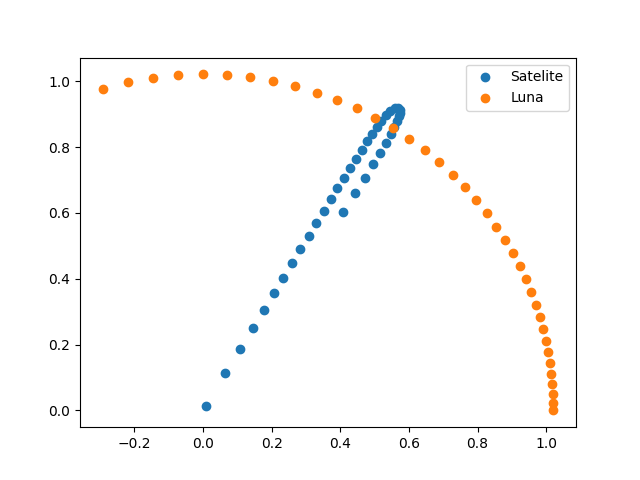

In [6]:
rsol = sol[:,0]
fisol = sol[:,1]
prsol = sol[:,2]
pfisol = sol[:,3]

scale = 1000
r = rsol[::scale]
fi = fisol[::scale]
fp = prsol[::scale]
pfi = pfisol[::scale]
fis = fissol[::scale]

x = r*np.cos(fi)
y = r*np.sin(fi)
xluna = (distancia/d)*np.cos(fis)
yluna = (distancia/d)*np.sin(fis)

plt.scatter(x,y,label='Satelite')
plt.scatter(xluna,yluna,label='Luna')
plt.legend()

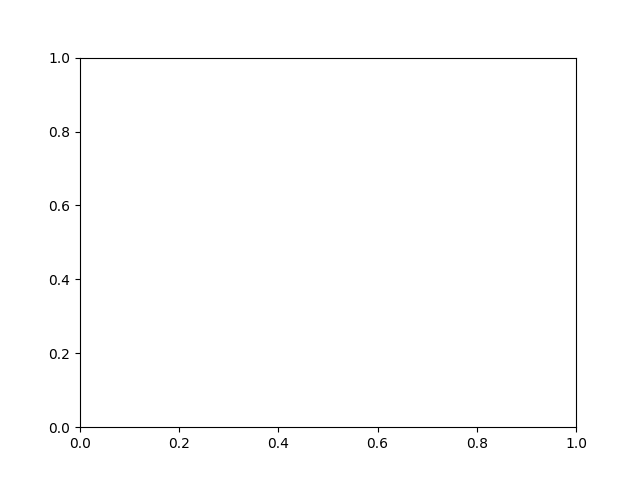

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

t1 = time[::scale]

def init():
    ax.clear()
    
def Update(i):
    
    init()
    ax.set_title(r't %.3f' %(t1[i]))
    plt.scatter(x[:i],y[:i],label='Satelite')
    plt.scatter(xluna[:i],yluna[:i],label='Luna')

Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)